In [1]:
import torch
import matplotlib.pyplot as plt

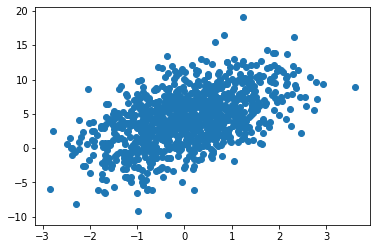

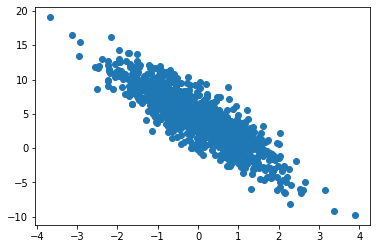

In [4]:
# 根据w和b生成带有噪声的数据集
def synthetic_data(w, b, num_examples):
    """⽣成y=Xw+b+噪声"""
    # x为标准状态分布，生成的列维度和w一样
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    # 噪声
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))


true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
# 第一维可视化
plt.scatter(features[:, 0].numpy(), labels.numpy())
plt.show()
# 第二维可视化
plt.scatter(features[:, 1].numpy(), labels.numpy())
plt.show()

In [5]:
import random


# 批数据迭代器
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [11]:
"""
定义计算模型：线性计算模型
"""


def linreg(X, w, b):
    return torch.matmul(X, w) + b


testX = torch.arange(1, 10).reshape(-1, 3)
testW = torch.tensor([[1, 2, 3]]).T
print(linreg(testX, testW, 1))
print(torch.mm(testX, testW) + 1)

tensor([[15],
        [33],
        [51]])
tensor([[15],
        [33],
        [51]])


In [14]:
# 损失函数L2
def squared_loss(y_hat, y):
    """均⽅损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2


squared_loss(torch.tensor([1, 2, 3]), torch.tensor([1, 2, 3]) + 1)

tensor([0.5000, 0.5000, 0.5000])

In [15]:
# 小批量随机梯度下降
def sgd(params, lr, batch_size):
    """
    包装器with torch.no_grad（）将所有require_grad标志临时设置为false。
    不希望PyTorch计算新定义的变量param的梯度（减少计算量），因为他只想更新它们的值。
    """
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()


In [25]:
# 初始化参数。注意requires_grad，进行自动梯度计算
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
"""
在每个迭代周期（epoch）中，我们使⽤data_iter函数遍历整个数据集，并将训练数据集中所有样本都使⽤
⼀次（假设样本数能够被批量⼤⼩整除）。这⾥的迭代周期个数num_epochs和学习率lr都是超参数，分别设
为3和0.03
"""
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss
batch_size = 10
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的⼩批量损失
        # 因为l形状是(batch_size,1)，⽽不是⼀个标量。 l中的所有元素被加到⼀起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()  #计算基于损失函数的梯度
        sgd([w, b], lr, batch_size)  # 使⽤参数的梯度更新参数
        with torch.no_grad():
            train_l = loss(net(features, w, b), labels)
    print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')
print(true_w, true_b, w, b)

epoch 1, loss 0.035279
epoch 2, loss 0.000131
epoch 3, loss 0.000047
tensor([ 2.0000, -3.4000]) 4.2 tensor([[ 1.9999],
        [-3.4002]], requires_grad=True) tensor([4.1992], requires_grad=True)
